<a href="https://colab.research.google.com/github/avikumart/LLM-GenAI-Transformers-Notebooks/blob/main/LLMs_deployment/Perplexity_Clone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U langchain langgraph==0.3.2 langchain_community openai langchain_openai duckduckgo-search html2text beautifulsoup4 langgraph-prebuilt

In [ ]:
import asyncio

In [ ]:
import os
import openai
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OpenAI')
os.environ['USER_AGENT'] = 'myagent

In [ ]:
ADDITIONAL_QUESTION_PROMPT = """You are tasked with analyzing a message to determine if it requires additional input from the user.
Your goal is to be conservative in asking for additional input, only indicating that more information is needed if it is relevant to answering the question or fulfilling the request in the message.
Use the following criteria to guide your decision:
- Is the core question or request clearly stated?
- Are all necessary details provided to understand the context?
- Would additional information significantly change or improve the response?
- Is the missing information essential or helpful?

Before giving your final answer, think through your analysis in a scratchpad:


Analyze the message here, considering the criteria above. Think step-by-step about whether additional input is truly necessary or if the message can be responded to with the given information.


After your analysis, provide your final answer in the following format:


[YES/NO]: (Choose YES if additional input is required, NO if it is not)
Justification: (Briefly explain your reasoning)

Remember to be conservative in asking for additional input. Only say YES if the additional information is highly relevant and necessary to properly address the message."""
SEARCH_QUERY_PROMPT = """You are a helpful AI assistant, create a list of 2-3 search queries based on the message"""
FINAL_NODE_SYSTEM_PROMPT = """You are a helpful AI assitant, answer the given question based on the context. Clearly cite the sources for your answer including the links for the sources next to the each point"""
FINAL_NODE_PROMPT = """Question: {question}
Context: {context}
Answer:"""

In [ ]:
from duckduckgo_search import DDGS

def aget_results(word):
    results = DDGS(proxy=None).text(word, max_results=2)
    return results

def search(queries):
    results = [aget_results(w) for w in queries]
    return results

In [ ]:
from langgraph.prebuilt import ToolNode
import json
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_structured_output_runnable
from langchain.agents.agent_types import AgentType
from typing import TypedDict, Annotated, Sequence, List
from langchain_core.pydantic_v1 import BaseModel, Field
import operator
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

model = ChatOpenAI(model="gpt-4o-mini",temperature=0)

class Queries(BaseModel):
    """List of search queries"""
    queries: List[str] = Field(
        description="List of the generated search queries"
    )

class SummaryState(TypedDict):
    content: str
    query: str

class OverallState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
    search_queries: list[str]
    search_results: list[str]
    page_content: list[str]
    page_summaries: Annotated[list, operator.add]

    @classmethod
    def additional_questions_node(cls,state):
      messages = state['messages']
      last_message = messages[-1]
      prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    ADDITIONAL_QUESTION_PROMPT,
                ),
                MessagesPlaceholder(variable_name="messages"),
                MessagesPlaceholder(variable_name="agent_scratchpad")
            ]
        )
      chain = prompt | model
      result = chain.invoke({
            "messages": messages,
            "agent_scratchpad": []
        })
      print(result.content)
      return {"next":result.content}

    @classmethod
    def where_to_go(cls,state):
      next = state['next']
      if "NO" in next:
        return "proceed"
      else:
        return "ask"

    @classmethod
    def ask_node(cls,state):
      messages = state['messages']
      user_question = messages[0]
      prompt = f"Ask any additional questions that are required to answer the question: {user_question.content}"
      question = model.invoke(prompt)
      return {"messages":[question]}

    @classmethod
    def new_question_node(cls,state):
      messages = state['messages']
      initial_question = messages[0]
      prompt = f"Reframe the initial question: {initial_question} based on the messages : {messages}"
      response = model.invoke(prompt)
      new_question = HumanMessage(content=response.content)
      return {"messages":[new_question]}

    @classmethod
    def search_query_node(cls,state):
      messages = state['messages']
      last_message = messages[-1]

      prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    SEARCH_QUERY_PROMPT,
                ),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )
      chain = prompt | model.with_structured_output(Queries)
      result = chain.invoke(messages)
      queries = result.queries
      return {"search_queries":queries}

    @classmethod
    def search_results_node(cls,state):
      queries = state['search_queries']
      results = search(queries)
      return {"search_results":results}

    @classmethod
    def web_scape_node(cls,state):
      search_results = state['search_results']
      urls = [result['href'] for search_result in search_results for result in search_result]
      #print(urls)
      loader = AsyncHtmlLoader(urls)
      docs = loader.load()
      html2text = Html2TextTransformer()
      docs_transformed = html2text.transform_documents(docs)
      return {"page_content":docs_transformed}

    @classmethod
    def generate_summary(cls,state: SummaryState):
      content = state['content'].page_content
      source = state['content'].metadata['source']
      query = state['query']
      prompt = f"Summarize the following content to answer the question: {query}, mention the source: {source}   \n\n  {content} "
      page_summary = model.invoke(prompt)
      return {"page_summaries":[page_summary.content]}

    @classmethod
    def continue_to_summarise_node(cls,state):
      return [Send("Generate Summary", {"content": p, "query": state['messages'][0].content}) for p in state['page_content']]

    @classmethod
    def final_result_node(cls,state):
      messages = state['messages']
      question = messages[-1]
      context = state['page_summaries']
      prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    FINAL_NODE_SYSTEM_PROMPT,
                ),
                (
                    "human",
                    FINAL_NODE_PROMPT,
                ),
            ]
        )
      input = {"question":messages[-1],"context":context}
      formatted_prompt = prompt.format_messages(**input)
      response = model.invoke(formatted_prompt)
      return {"messages":[response]}

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [ ]:
from langgraph.graph import StateGraph, END
perplexity = StateGraph(OverallState)
perplexity.add_node('Additional Questions',OverallState.additional_questions_node)
perplexity.add_node('Ask',OverallState.ask_node)
perplexity.add_node('New Question',OverallState.new_question_node)
perplexity.add_node('Query Generator',OverallState.search_query_node)
perplexity.add_node('Search Results',OverallState.search_results_node)
perplexity.add_node('Web Scraper',OverallState.web_scape_node)
perplexity.add_node('Generate Summary',OverallState.generate_summary)
perplexity.add_node('Final Result',OverallState.final_result_node)

perplexity.set_entry_point('Additional Questions')
perplexity.set_finish_point('Final Result')

perplexity.add_conditional_edges('Additional Questions',OverallState.where_to_go,{'proceed':'Query Generator','ask':'Ask'})
perplexity.add_edge('Ask','New Question')
perplexity.add_edge('New Question','Query Generator')
perplexity.add_edge('Query Generator','Search Results')
perplexity.add_edge('Search Results','Web Scraper')
perplexity.add_conditional_edges('Web Scraper', OverallState.continue_to_summarise_node,['Generate Summary'])
perplexity.add_edge('Generate Summary','Final Result')

perplexity_graph = perplexity.compile(checkpointer=memory, interrupt_after=["Ask"])

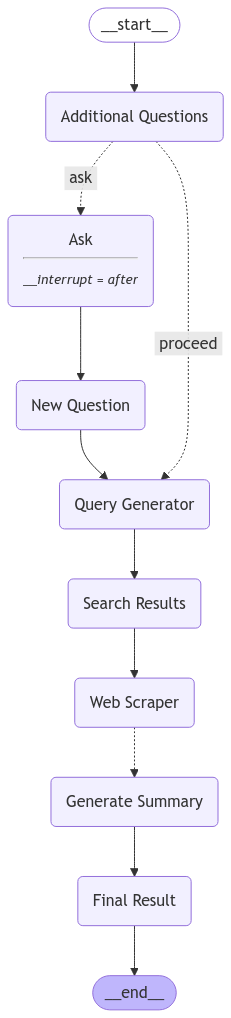

In [ ]:
from IPython.display import Image, display

try:
    display(Image(perplexity_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
config = {"configurable": {"thread_id": '1'}}

In [ ]:
from langchain_core.messages import BaseMessage, HumanMessage
inputs = {
    "messages": [HumanMessage(content="Champions Trophy 2025 Match")],
}

In [ ]:
outputs = perplexity_graph.invoke(inputs, config)

Scratchpad Analysis:
1. The core question or request is not clearly stated. The message simply mentions "Champions Trophy 2025 Match" without specifying what information is being sought (e.g., schedule, teams, results, tickets).
2. There are no details provided to understand the context or the specific inquiry related to the Champions Trophy 2025 Match.
3. Additional information would significantly change or improve the response, as it is unclear what aspect of the match the user is interested in.
4. The missing information is essential to provide a relevant and accurate response.

Final Answer:
[YES]: Additional input is required to clarify what specific information the user is seeking regarding the Champions Trophy 2025 Match.


In [ ]:
from IPython.display import Markdown, display
display(Markdown(outputs['messages'][-1].content))

To provide you with the most accurate information about the Champions Trophy 2025 match, I need to clarify a few details:

1. **Specific Match**: Are you asking about a specific match within the tournament, or do you want general information about the tournament format and schedule?

2. **Teams**: Are you interested in a particular team or teams that will be participating in the Champions Trophy 2025?

3. **Location**: Do you want to know about the venue or host country for the matches?

4. **Tickets and Viewing**: Are you looking for information on how to watch the matches or purchase tickets?

5. **Players**: Are you interested in information about specific players or teams' rosters?

6. **Historical Context**: Would you like to know about past Champions Trophy tournaments or how the 2025 edition compares to previous ones?

Please provide more details so I can assist you better!

In [ ]:
current_state = perplexity_graph.get_state(config)
print(current_state)

StateSnapshot(values={'messages': [HumanMessage(content='Champions Trophy 2025 Match', additional_kwargs={}, response_metadata={}), AIMessage(content="To provide you with the most accurate information about the Champions Trophy 2025 match, I need to clarify a few details:\n\n1. **Specific Match**: Are you asking about a specific match within the tournament, or do you want general information about the tournament format and schedule?\n\n2. **Teams**: Are you interested in a particular team or teams that will be participating in the Champions Trophy 2025?\n\n3. **Location**: Do you want to know about the venue or host country for the matches?\n\n4. **Tickets and Viewing**: Are you looking for information on how to watch the matches or purchase tickets?\n\n5. **Players**: Are you interested in information about specific players or teams' rosters?\n\n6. **Historical Context**: Would you like to know about past Champions Trophy tournaments or how the 2025 edition compares to previous ones?\

In [ ]:
last_message = current_state.values["messages"][-1]
print(last_message.content)

To provide you with the most accurate information about the Champions Trophy 2025 match, I need to clarify a few details:

1. **Specific Match**: Are you asking about a specific match within the tournament, or do you want general information about the tournament format and schedule?

2. **Teams**: Are you interested in a particular team or teams that will be participating in the Champions Trophy 2025?

3. **Location**: Do you want to know about the venue or host country for the matches?

4. **Tickets and Viewing**: Are you looking for information on how to watch the matches or purchase tickets?

5. **Players**: Are you interested in information about specific players or teams' rosters?

6. **Historical Context**: Would you like to know about past Champions Trophy tournaments or how the 2025 edition compares to previous ones?

Please provide more details so I can assist you better!


In [ ]:
input_message = [HumanMessage(content="I am referring to the recent cricket match between Australia and Afghanistan")]

In [ ]:
perplexity_graph.update_state(
    config,
    {"messages": input_message},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff6942-6849-666f-8003-77c3ec4b9e88'}}

In [ ]:
outputs = perplexity_graph.invoke(None, config)

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1377: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
Fetching pages: 100%|##########| 6/6 [00:01<00:00,  3.87it/s]


In [ ]:
from IPython.display import Markdown, display
display(Markdown(outputs['messages'][-1].content))

In the ICC Champions Trophy 2025 match between Australia and Afghanistan, which took place on February 28, 2025, at Gaddafi Stadium in Lahore, the game was ultimately called off due to rain. Here are the key details:

1. **Match Summary**: Afghanistan batted first and set a target of 273 runs, scoring 273 runs in total. Notable contributions came from Sediqullah Atal, who scored 85 runs, and Azmatullah Omarzai, who added 67 runs. Australia's bowling was led by Ben Dwarshuis, who took three wickets during Afghanistan's innings. In response, Australia was at 109 runs for the loss of one wicket in 12.5 overs when rain interrupted play, leading to the match being abandoned. As a result, both teams shared the points, but Australia advanced to the semi-finals due to their position in the chase [Sporting News](https://www.sportingnews.com/au/cricket/news/australia-afghanistan-champions-trophy-2025-live-updates-scores-result-highlights/ad89f25b3f67e5308b92779d), [CricTracker](https://www.crictracker.com/cricket-stats-mania/champions-trophy-2025-afghanistan-vs-australia-match-10-stats-review-of-player-records-and-achieved-milestones-0207/), [ESPN Cricinfo](https://www.espncricinfo.com/series/icc-champions-trophy-2024-25-1459031/afghanistan-vs-australia-10th-match-group-b-1466423/live-cricket-score).

2. **Notable Performances**: Travis Head made headlines by scoring the fastest fifty in Champions Trophy history, reaching his fifty in just 34 balls. At the time of the rain delay, he was unbeaten on 59 runs. Additionally, Hashmatullah Shahidi became Afghanistan's fourth-highest ODI run-scorer during this match [CricTracker](https://www.crictracker.com/cricket-stats-mania/champions-trophy-2025-afghanistan-vs-australia-match-10-stats-review-of-player-records-and-achieved-milestones-0207/).

3. **Implications for Teams**: With this result, Australia secured four points and advanced to the semi-finals. Afghanistan, having three points, needed a significant defeat of South Africa by England in their next match to have a chance of advancing [ESPN Cricinfo](https://www.espncricinfo.com/series/icc-champions-trophy-2024-25-1459031/afghanistan-vs-australia-10th-match-group-b-1466423/live-cricket-score).

For further details and highlights, you can check the following sources:
- [Cricbuzz Highlights](https://www.cricbuzz.com/cricket-videos/119102/highlights-afghanistan-v-australia-icc-champions-trophy-2025)
- [SuperSport Highlights](https://supersport.com/cricket/icc-champions-trophy-2025/video/6b2818b4-52b4-4ea1-b8ca-94757a36893b/afghanistan-v-australia-match-highlights-icc-champions-trophy)